referencing:

https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d


In [1]:
%env AWS_ACCESS_KEY_ID=""
%env AWS_SECRET_ACCESS_KEY_ID=""
%env AWS_REGION_NAME=""
%env AWS_BUCKET_NAME=""

%env MODEL_VERSION=1

env: AWS_ACCESS_KEY_ID=""
env: AWS_SECRET_ACCESS_KEY_ID=""
env: AWS_REGION_NAME=""
env: AWS_BUCKET_NAME=""
env: MODEL_VERSION=1


In [2]:
# cmd to check gpu process
!nvidia-smi

Sun Sep 11 09:40:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

In [4]:
!pip install -q tf-models-official==2.7.0

In [5]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [7]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [8]:
import pandas as pd

data = pd.read_csv('../gdrive/MyDrive/bert-chatbot/sample.csv')

data = data[data['intent']!='FALLBACK']
data = data[data['intent']!='FORBIDDEN']
data = data[~data['intent'].str.startswith("OTHERS_")]

df = pd.DataFrame(data)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['intent'])

num_of_classes = len(le.classes_)

from sklearn.model_selection import train_test_split
y = tf.keras.utils.to_categorical(le.transform(df["intent"]))
x_train, x_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.25)


print(len(df))
print(le.classes_)
df

1638
['ADDRESS' 'AGE' 'APPRAISAL_BAD' 'APPRAISAL_COMPLAIN' 'APPRAISAL_GOOD'
 'APPRAISAL_LIKE_BOT' 'APPRAISAL_THANK_YOU' 'ASK_FOR_HELP'
 'ASK_FOR_REAL_PERSON' 'BOT_FUNCTIONS' 'BOT_NAME' 'BOT_NOT_UNDERSTAND'
 'CHITCHAT' 'GENDER' 'GREETINGS' 'GREETINGS_BYE' 'INAPPROPRIATE_ACTION'
 'INVESTMENT' 'OFFICE_HOUR' 'USER_EMOTIONS' 'USER_NOT_UNDERSTAND']


,intent,text
0,GENDER,Are you woman
1,GENDER,are you a boy?
2,GENDER,Are you female
3,GENDER,想知你係男定係女?
4,GENDER,你係咪女仔？
...,...,...
5926,INVESTMENT,琴日入完tqqq 今日即跌
5927,INVESTMENT,熊軍會戰勝歸來
5928,INVESTMENT,有時燈呢家野 真係唔到自己唔信
5929,INVESTMENT,今晚呢啲時候真係唔係入貨嘅時間，上落太大


In [9]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3"

# only chinese model
#tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4"
#tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_zh_preprocess/3"


print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [10]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [11]:
text_test = ['apple a p p l e']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101 72894 10284   169   184   184   180   173   102     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
def build_classifier_model():
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  encoder_inputs = preprocessing_layer(text_input)
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  # comment out dropout layer as we have underfitting
  # net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [13]:
# custom sequence length
"""
def build_classifier_model():
  preprocessor = hub.load(tfhub_handle_preprocess)
  text_input = [tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')]
  tokenize = hub.KerasLayer(preprocessor.tokenize)
  tokenized_inputs = [tokenize(segment) for segment in text_input]
  seq_length = 80  # Your choice here.
  bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length), name='preprocessing') 
  encoder_inputs = bert_pack_inputs(tokenized_inputs)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  #net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)
"""

"\ndef build_classifier_model():\n  preprocessor = hub.load(tfhub_handle_preprocess)\n  text_input = [tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')]\n  tokenize = hub.KerasLayer(preprocessor.tokenize)\n  tokenized_inputs = [tokenize(segment) for segment in text_input]\n  seq_length = 80  # Your choice here.\n  bert_pack_inputs = hub.KerasLayer(\n    preprocessor.bert_pack_inputs,\n    arguments=dict(seq_length=seq_length), name='preprocessing') \n  encoder_inputs = bert_pack_inputs(tokenized_inputs)\n  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')\n  outputs = encoder(encoder_inputs)\n  net = outputs['pooled_output']\n  #net = tf.keras.layers.Dropout(0.1)(net)\n  net = tf.keras.layers.Dense(num_of_classes, activation='softmax', name='classifier')(net)\n  return tf.keras.Model(text_input, net)\n"

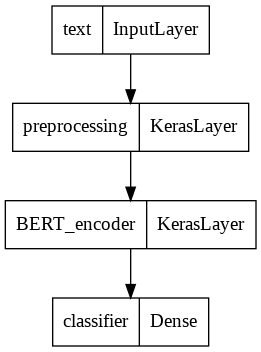

In [14]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)


In [15]:
classifier_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [16]:
"""
epochs = 5
steps_per_epoch = num_of_classes
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
print(steps_per_epoch)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,                                          
                                          optimizer_type='adamw')
"""

"\nepochs = 5\nsteps_per_epoch = num_of_classes\nnum_train_steps = steps_per_epoch * epochs\nnum_warmup_steps = int(0.1*num_train_steps)\nprint(steps_per_epoch)\n\ninit_lr = 3e-5\noptimizer = optimization.create_optimizer(init_lr=init_lr,\n                                          num_train_steps=num_train_steps,\n                                          num_warmup_steps=num_warmup_steps,                                          \n                                          optimizer_type='adamw')\n"

In [17]:
from tensorflow.keras.optimizers import Adam
classifier_model.compile(Adam(learning_rate=3e-5), loss = "categorical_crossentropy", metrics = ["accuracy"]) # learning_rate recommand from the paper
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [18]:
# Once we have defined the model’s structure, we can compile and fit it. 
# We choose to train the model for 30 epochs, 
# but we also use the EarlyStopping callback in order to monitor the validation loss during training: 
# if the metric does not improve for at least 3 epochs (patience = 3), # 
# the training is interrupted and the weights from the epoch where the validation loss showed the best value (i.e. lowest) are restored (restore_best_weights = True)

n_epochs = 30

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True,
                                                      )

model_fit = classifier_model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/30
39/39 [==============================] - 51s 971ms/step - loss: 2.3269 - accuracy: 0.3445 - val_loss: 1.8755 - val_accuracy: 0.4585
Epoch 2/30
39/39 [==============================] - 37s 942ms/step - loss: 1.3113 - accuracy: 0.6458 - val_loss: 1.1982 - val_accuracy: 0.6537
Epoch 3/30
39/39 [==============================] - 37s 944ms/step - loss: 0.6969 - accuracy: 0.8208 - val_loss: 0.8143 - val_accuracy: 0.7634
Epoch 4/30
39/39 [==============================] - 37s 952ms/step - loss: 0.3480 - accuracy: 0.9243 - val_loss: 0.7484 - val_accuracy: 0.7878
Epoch 5/30
39/39 [==============================] - 37s 959ms/step - loss: 0.2171 - accuracy: 0.9544 - val_loss: 0.7218 - val_accuracy: 0.8024
Epoch 6/30
39/39 [==============================] - 38s 976ms/step - loss: 0.1359 - accuracy: 0.9715 - val_loss: 0.6446 - val_accuracy: 0.8268
Epoch 7/30
39/39 [==============================] - 39s 1s/step - loss: 0.1099 - accuracy: 0.9796 - val_loss: 0.6635 - val_accuracy: 0.8220
Ep

In [19]:
import numpy as np
pred = classifier_model.predict(["tu es un garçon?"])

top_n_indices = pred[0].argsort()[-5:][::-1]
top_n_indices


array([13, 10, 12,  5,  0])

In [20]:
for label, score in zip(le.classes_[top_n_indices], pred[0][top_n_indices]):
  print(str(label) + " "+ str(score))


GENDER 0.985857
BOT_NAME 0.004592923
CHITCHAT 0.0023915144
APPRAISAL_LIKE_BOT 0.0018728101
ADDRESS 0.00054783566


In [21]:
import json

f = open('../gdrive/MyDrive/bert-chatbot/reply.json')
response = json.load(f)
print(response['GENDER'])

[{'en': "I don't know my gender yet, but I was created by a male developer.", 'zh': '我仲未知我係男定女，但我嘅開發者係男人嚟。', 'fr': 'Je ne sais pas encore, mais mon développeur est un homme.'}]


In [22]:
print("response language: en\n")
lang = 'en'
query = ["你好!", "hello", "琴日入完tqqq 今日即跌", "你辦公時間是甚麼?", "you perform bad"]

predictions = classifier_model.predict(query)
for i, pred in enumerate(predictions):
  predictedIntent = le.classes_[pred.argsort()[::-1][0]]
  print("Query: {}".format(query[i]))
  print("Response: {} [Intention predicted: {}]".format(response.get(predictedIntent)[0][lang], predictedIntent))

response language: en

Query: 你好!
Response: Hi, how is your day? [Intention predicted: GREETINGS]
Query: hello
Response: Hi, how is your day? [Intention predicted: GREETINGS]
Query: 琴日入完tqqq 今日即跌
Response: I lost a lot on stock, sooner I won't even have money to pay the rent cost on AWS EC2... which means you may not reach me later. [Intention predicted: INVESTMENT]
Query: 你辦公時間是甚麼?
Response: As long as the server keeps running, I work 7/24. So just reach me anytime you are free. [Intention predicted: OFFICE_HOUR]
Query: you perform bad
Response: Sorry sorry, I know I am not smart enough. Maybe I will improve in the future with more training data. [Intention predicted: APPRAISAL_BAD]


In [23]:
print("response language: zh\n")
lang = 'zh'
query = ["你好!", "hello", "琴日入完tqqq 今日即跌", "你辦公時間是甚麼?", "you perform bad"]

predictions = classifier_model.predict(query)
for i, pred in enumerate(predictions):
  predictedIntent = le.classes_[pred.argsort()[::-1][0]]
  print("Query: {}".format(query[i]))
  print("Response: {} [Intention predicted: {}]".format(response.get(predictedIntent)[0][lang], predictedIntent))

response language: zh

Query: 你好!
Response: 你好呀，今日過成點? [Intention predicted: GREETINGS]
Query: hello
Response: 你好呀，今日過成點? [Intention predicted: GREETINGS]
Query: 琴日入完tqqq 今日即跌
Response: 我美股豬咗好多錢吖，我之後可能冇錢去俾AWS EC2 租金添，話唔定你之後會見我唔到啦。 [Intention predicted: INVESTMENT]
Query: 你辦公時間是甚麼?
Response: 只要個server 仲行緊，咁我就會7/24 返工嘅，所以你幾時揾我都得。 [Intention predicted: OFFICE_HOUR]
Query: you perform bad
Response: 真係唔好意思，我知我仲未夠醒目，可能我遲啲有多啲training data會再聰明啲。 [Intention predicted: APPRAISAL_BAD]


In [24]:
print("response language: fr\n")
lang = 'fr'
query = ["你好!", "hello", "琴日入完tqqq 今日即跌", "你辦公時間是甚麼?", "you perform bad"]

predictions = classifier_model.predict(query)
for i, pred in enumerate(predictions):
  predictedIntent = le.classes_[pred.argsort()[::-1][0]]
  print("Query: {}".format(query[i]))
  print("Response: {} [Intention predicted: {}]".format(response.get(predictedIntent)[0][lang], predictedIntent))

response language: fr

Query: 你好!
Response: Salut, comment est votre journée ? [Intention predicted: GREETINGS]
Query: hello
Response: Salut, comment est votre journée ? [Intention predicted: GREETINGS]
Query: 琴日入完tqqq 今日即跌
Response: J'ai perdu beaucoup de stock, plus tôt je n'aurai même pas d'argent pour payer les frais de retour sur AWS EC2... Ce qui signifie que vous ne pourrez plus me joindre plus tard. [Intention predicted: INVESTMENT]
Query: 你辦公時間是甚麼?
Response: Si le serveur tourne, je travaille 7/24. Alors rendez-moi quand tu es libre. [Intention predicted: OFFICE_HOUR]
Query: you perform bad
Response: Désolé désolé, je sais que je ne suis pas assez intelligent. Peut-être que je m'améliorerai à l'avenir avec plus de données d'entraînement. [Intention predicted: APPRAISAL_BAD]


In [25]:
# copy model to drive
export_dir='./saved_model/'
model_version = os.getenv("MODEL_VERSION")
tf.saved_model.save(classifier_model, export_dir=export_dir)
%cp -av /content/saved_model /gdrive/MyDrive/bert-chatbot/model/{model_version}

'/content/saved_model' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model'
'/content/saved_model/saved_model.pb' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model/saved_model.pb'
'/content/saved_model/variables' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model/variables'
'/content/saved_model/variables/variables.index' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model/variables/variables.index'
'/content/saved_model/variables/variables.data-00000-of-00001' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model/variables/variables.data-00000-of-00001'
'/content/saved_model/assets' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model/assets'
'/content/saved_model/assets/vocab.txt' -> '/gdrive/MyDrive/bert-chatbot/model/1/saved_model/assets/vocab.txt'


In [26]:
'''
import boto3

session = boto3.Session(
    aws_access_key_id= os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY_ID"),
    region_name=os.getenv("AWS_REGION_NAME")
)
s3 = session.resource('s3')
bucket = s3.Bucket(os.getenv("AWS_BUCKET_NAME"))


path = "./saved_model"
for subdir, dirs, files in os.walk(path):
    for file in files:
        full_path = os.path.join(subdir, file)
        with open(full_path, 'rb') as data:
            bucket.put_object(Key="saved_model_bert/" + os.getenv("MODEL_VERSION") + "/" + full_path[len(path)+1:], Body=data)
'''

'\nimport boto3\n\nsession = boto3.Session(\n    aws_access_key_id= os.getenv("AWS_ACCESS_KEY_ID"),\n    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY_ID"),\n    region_name=os.getenv("AWS_REGION_NAME")\n)\ns3 = session.resource(\'s3\')\nbucket = s3.Bucket(os.getenv("AWS_BUCKET_NAME"))\n\n\npath = "./saved_model"\nfor subdir, dirs, files in os.walk(path):\n    for file in files:\n        full_path = os.path.join(subdir, file)\n        with open(full_path, \'rb\') as data:\n            bucket.put_object(Key="saved_model_bert/" + os.getenv("MODEL_VERSION") + "/" + full_path[len(path)+1:], Body=data)\n'